In [6]:
import os
%env OPENAI_API_KEY=<your token>
%env REPLICATE_API_TOKEN=<your token>
print(os.environ.get("OPENAI_API_KEY"))

env: OPENAI_API_KEY=<your token>
env: REPLICATE_API_TOKEN=<your token>
<your token>


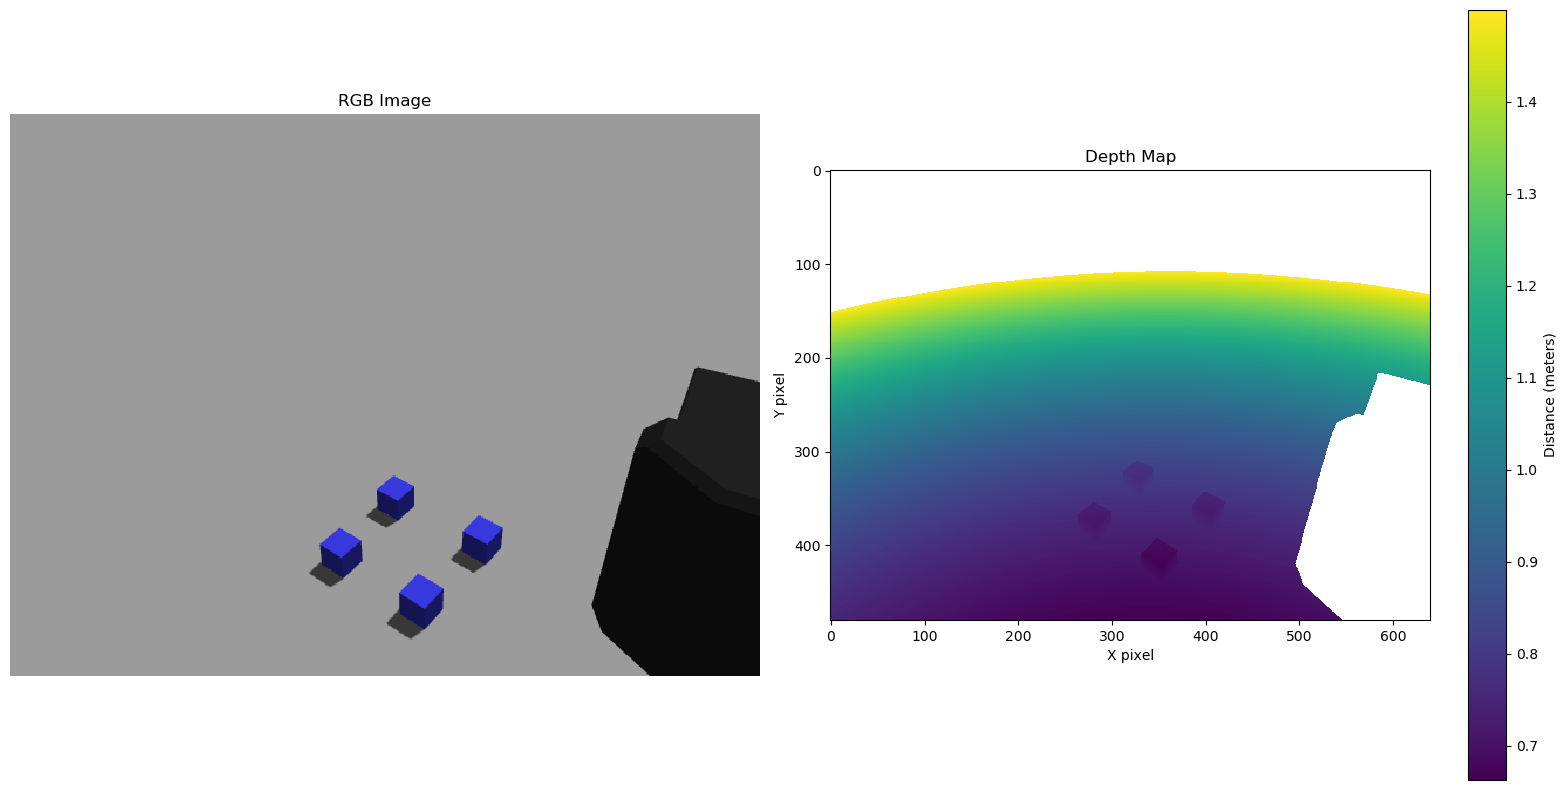

Using OpenAI API with model gpt-4o
Sending prompt to OpenAI...
Base response received.
To construct the goal structure, the first image shows a house-like shape composed of a square base and a triangular roof on top. We can break it down into buildable parts using the provided blocks.

Here's a step-by-step plan:

**Block Positions:**
- **Square Base:** 
  - Block 1: Bottom-left of the square (2, 0) to (4, 2).
  - Block 2: Bottom-right of the square (4, 0) to (6, 2).

- **Triangular Roof:**
  - Block 3: Left part of the roof peak (3, 2) to (5, 4).

Given the arrangement shown in the current environment's second image, the blocks are in a 2x2 grid at these positions: 
- Bottom Row: Block 1 at (0, 0), Block 2 at (1, 0)
- Top Row: Block 3 at (0, 1); Block 4 (not needed) at (1, 1)

### Instructions:

**ACTION 1:** 
- `{ pos_init: {x: 0, y: 0}, pos_finale: {x: 2, y: 0}, notice: "Pick and place the bottom-left block for the square base, approach from the top." }`

**ACTION 2:** 
- `{ pos_ini

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from visioncraft.locobot.camera import LocobotCamera
import rospy
from visioncraft.vlm.vlm_pipeline import VLMPipeline
import os

def visualize_depth_map(cam, min_distance=0.5, max_distance=1.5):
    """
    Create a depth map visualization and show the RGB image using matplotlib
    """
    # Get the image
    img = cam.get_image()
    if img is None:
        print("No image received")
        return
        
    height, width = img.shape[:2]
    
    # Create depth map
    depth_map = np.full((height, width), np.nan)
    
    # Fill depth map with distances
    for y in range(height):
        for x in range(width):
            point = cam.get_point_at_pixel(x, y)
            if point is not None:
                # Calculate distance from camera (Euclidean distance)
                distance = np.sqrt(point[0]**2 + point[1]**2 + point[2]**2)
                if min_distance <= distance <= max_distance:
                    depth_map[y, x] = distance  # Only keep valid distances
    
    # Create visualization
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    
    # Plot RGB image
    axs[0].imshow(img)
    axs[0].set_title('RGB Image')
    axs[0].axis('off')
    

    # Plot depth map
    depth_plot = axs[1].imshow(depth_map, cmap='viridis')
    axs[1].set_title('Depth Map')
    axs[1].set_xlabel('X pixel')
    axs[1].set_ylabel('Y pixel')
    fig.colorbar(depth_plot, ax=axs[1], label='Distance (meters)')
    
    plt.tight_layout()
    plt.show()

def get_depth_map(cam, min_distance=0.5, max_distance=1.5):
    """
    Get the depth map from the camera
    """
    # Get the image
    img = cam.get_image()
    if img is None:
        print("No image received")
        return
        
    height, width = img.shape[:2]
    
    # Create depth map
    depth_map = np.full((height, width), np.nan)
    
    # Fill depth map with distances
    for y in range(height):
        for x in range(width):
            point = cam.get_point_at_pixel(x, y)
            if point is not None:
                # Calculate distance from camera (Euclidean distance)
                distance = np.sqrt(point[0]**2 + point[1]**2 + point[2]**2)
                if min_distance <= distance <= max_distance:
                    depth_map[y, x] = distance  # Only keep valid distances
    
    return depth_map, height, width

def main():
    cam = LocobotCamera()
    cam.pan(0.5)
    cam.tilt(0.6)
    img = cam.get_image()
        
    # Visualize depth map and image
    visualize_depth_map(cam)
    plt.imsave('../resources/rgb_image.png', img)

    vlm_pipeline = VLMPipeline(model_name="gpt-4o", openai_api_key=os.environ.get("OPENAI_API_KEY"))
    vlm_pipeline.set_current_image("../resources/rgb_image.png")
    vlm_pipeline.set_goal_image("../resources/simple_house.png")
    json_answer = vlm_pipeline.run_pipeline()
    for actions in json_answer:
            for action in json_answer[actions]:
                # Each action to accomplish
                print(f"Action: {action}")
                pos_init = action['pos_init']
                depth_map, height, width = get_depth_map(cam)
                x = int(pos_init["x"]/100 * width)
                y = int(pos_init["y"]/100 * height)
                print(f"X: {x}, Y: {y}")
                if depth_map[y, x] is not None:
                    print(f"Distance: {depth_map[y, x]} m")
                else:
                    print("No valid distance found at this pixel.")

    # Wait for some data to be received
    rospy.sleep(1.0)


if __name__ == '__main__':
    main()
